## Forecasting Stock Prices with LSTM

**Objective**  
To visualize and analyze stock price time series data, extract trends and seasonality, and forecast future stock prices using an LSTM model.

**Dataset**  
`Dataset Source:` Yahoo Finance  
`Dataset:` Daily stock prices for Apple Inc. (AAPL) over the last 5 years.

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

**Download the dataset**

In [2]:
df = yf.download('AAPL', start='2018-01-01', end='2023-01-01')
df.reset_index(inplace=True)
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,42.540001,43.075001,42.314999,43.064999,40.568924,102223600
1,2018-01-03,43.132500,43.637501,42.990002,43.057499,40.561867,118071600
2,2018-01-04,43.134998,43.367500,43.020000,43.257500,40.750263,89738400
3,2018-01-05,43.360001,43.842499,43.262501,43.750000,41.214226,94640000
4,2018-01-08,43.587502,43.902500,43.482498,43.587502,41.061134,82271200


**Data Preprocessing**  
Convert the `Date` column to datetime format and handle any missing values.

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Handle missing values by forward filling
df.fillna(method='ffill', inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_19184\1558512105.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


**Data Visualization**  
Visualize the closing prices over time and include moving averages.

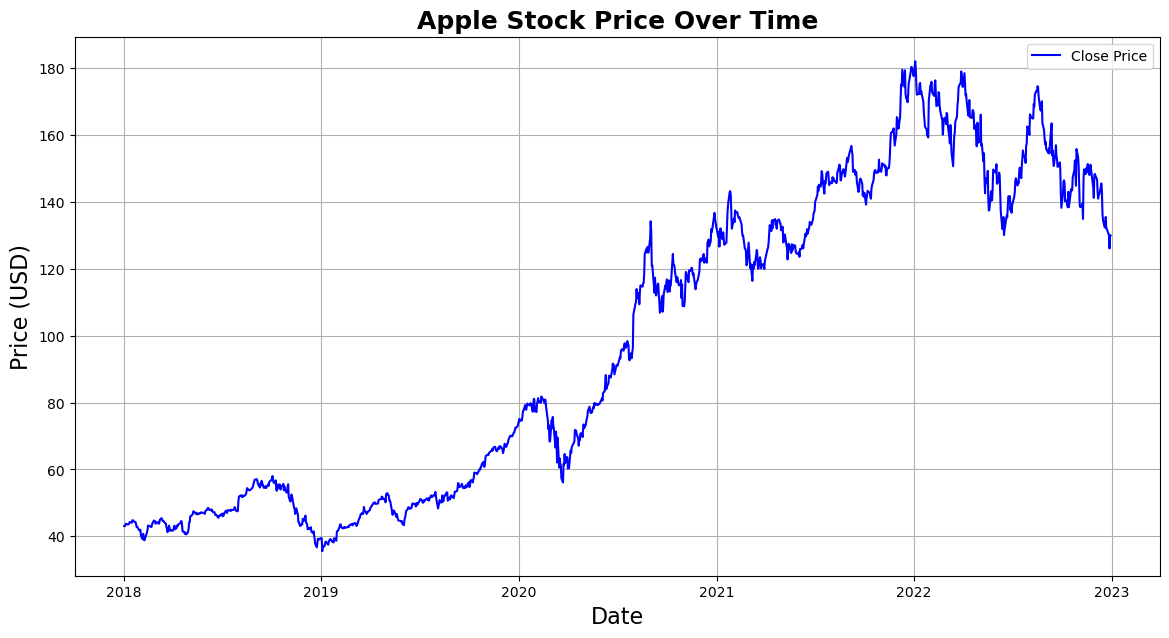

In [4]:
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title('Apple Stock Price Over Time', fontweight='bold', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price (USD)', fontsize=16)
plt.grid()
plt.legend()
plt.show()

**Adding Moving Average**

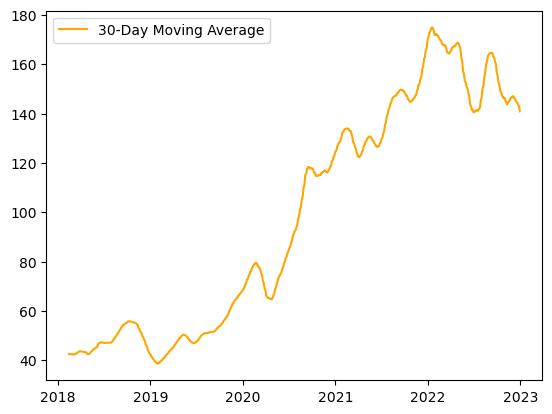

In [5]:
df['MA_30'] = df['Close'].rolling(window=30).mean()
plt.plot(df['MA_30'], label='30-Day Moving Average', color='orange')
plt.legend()
plt.show()

**Feature Engineering**  
Create features suitable for LSTM input.

In [6]:
# Normalize the dataset
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

In [7]:
# Create training data
training_data_len = int(np.ceil(0.8 * len(scaled_data)))

# Create the training dataset
train_data = scaled_data[0:training_data_len]

# Split the data into X_train and y_train
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

**Build the LSTM Model**  
Construct and compile the LSTM model.

In [8]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Train the Model**  
Fit the model to the training data.

In [9]:
model.fit(x_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
948/948 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 0.0074
Epoch 2/10
948/948 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - loss: 0.0024
Epoch 3/10
948/948 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - loss: 0.0025
Epoch 4/10
948/948 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - loss: 0.0022
Epoch 5/10
948/948 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - loss: 0.0019
Epoch 6/10
948/948 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - loss: 0.0019
Epoch 7/10
948/948 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - loss: 0.0021
Epoch 8/10
948/948 ━━━━━━━━━━━━━━━━━━━━ 44s 46ms/step - loss: 0.0017
Epoch 9/10
948/948 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - loss: 0.0021
Epoch 10/10
948/948 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - loss: 0.0015


**Create Testing Dataset**  
Prepare the test dataset to evaluate the model.

In [10]:
test_data = scaled_data[training_data_len - 60:]

x_test = []
y_test = df['Close'][training_data_len:].values

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

**Make Predictions**  
Use the model to predict future prices.

In [11]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)  # Inverse scaling

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step


**Visualize Predictions**  
Compare the predicted prices with actual prices.

C:\Users\PC\AppData\Local\Temp\ipykernel_19184\1040269613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


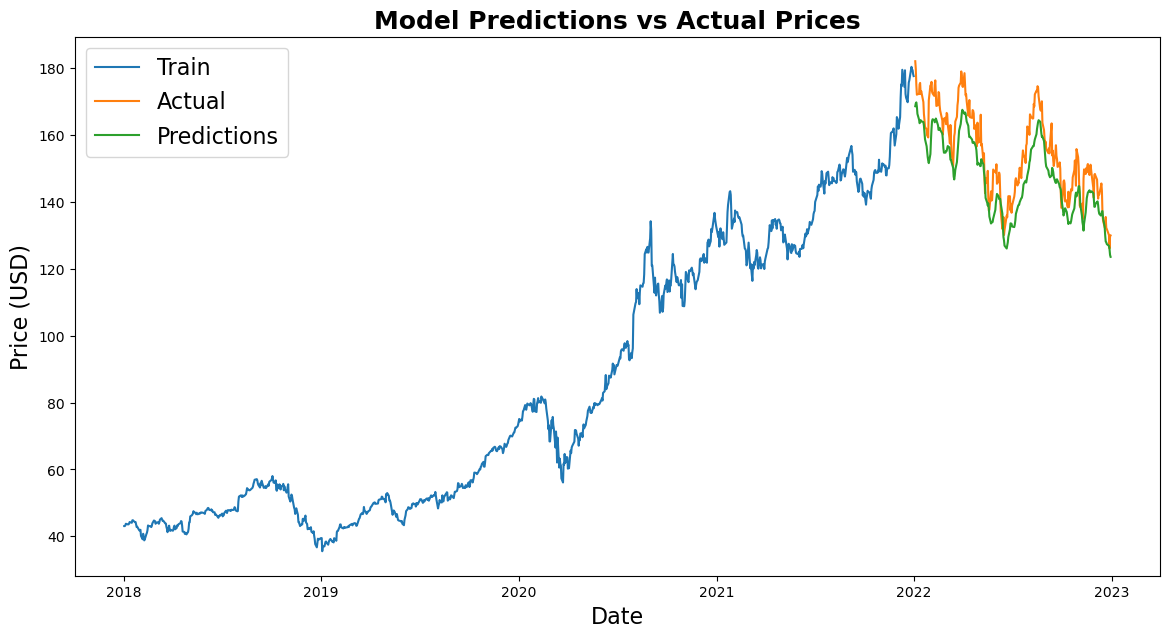

In [12]:
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(14, 7))
plt.title('Model Predictions vs Actual Prices', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price (USD)', fontsize=16)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], fontsize=16)
plt.show()

---